# Grover's Algorithm with hierarcqal


In [1]:
#!pip install qiskit-aer

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from hierarqcal import Qinit, Qmask, Qunitary, Qpivot, Qcycle, Qunmask

mpl_backend = mpl.get_backend()

## Background

### The algorithm

Grover's algorithm provides an optimal method to amplify the amplitude of a specific state. This specific state is usually referred to as the *target state* which we label  $T$. The algorithm requires an oracle, that is a "black-box" with the ability to change the sign of the amplitude of the target state. This processes is commonly described as *marking* the target. 

Grover's algorithm works in two steps:

Step 1: Apply the oracle. 

Step 2: Reflect in a hyperplane orthogonal to some state $\psi$. 

It turns out that step 1 and 2 are in fact the same operation, namely a reflection. Reflecting a vector is nothing other than changing the sign of the component of the vector that is parallel to the normal to the (hyper)plane of reflection, while doing nothing to all other components of the vector. Step 1 is therefore nothing other than a reflection in the hyperplane orthogonal to the target state $T$. 

A reflection in the hyperplane orthogonal to a vector $\hat{n}$ is given in Dirac notation by
$$U_{\text{reflect}} = \mathbb{I} - 2|\hat{n}  \rangle\langle \hat{n} |$$
where $|\hat{n}\rangle$ is the state associated with the normal vector $\hat{n}$.

We shall see that the algorithm performs optimally if $\psi$,  $T$ and the initial state of the system all lie in the same plane.

### *Side note* 
In most descriptions of Grover's algorithm the second step is characterized as a reflection across a state in the plane, usually the equal superposition of all computational basis states. A reflection across a state can be written as
$$V = - \mathbb{I} + 2|\hat{r}  \rangle\langle \hat{r} |$$
where $\hat{r}$ is the state across which we reflect. It is straightforward to check that $V$ can also be written as
$$V = - \big(\mathbb{I} - 2|\hat{r}_\perp  \rangle\langle \hat{r}_\perp | \big)$$
where $\hat{r}_\perp$ is a vector perpendicular to $\hat{r}$.
Since $\psi$ is some arbitrary state, $V$ and $U_{\text{reflect}}$ differ only by a global phase factor.


### Evolution of the initial state

Assuming that we started in some state $\phi$, which we denote in Dirac notation as $|\phi\rangle$, one iteration of Grover's algorithm transforms the initial state as follows
$$|\phi\rangle \rightarrow (\mathbb{I} - 2|\psi \rangle\langle \psi|)(\mathbb{I} - 2|T \rangle\langle T|)|\phi\rangle\,.$$

One can visualize this process by first noticing that $|\phi\rangle$ can be separated into two components: A component lying in the plane spanned by $|T\rangle$ and $|\psi\rangle$ and a component orthogonal to this plane. In this way we can visualize the process in three dimensions, despite the fact that the process occurs in a high-dimensional space.

Note that the component of $\phi$ orthogonal to the plane spanned by $T$ and $\psi$ is an eigenstate of the transformation. It therefore represents a portion of the initial state that is inaccessible to the algorithm. Hence, the algorithm performs optimally if $\psi$,  $T$ and $\phi$ all lie in the same plane, as mentioned earlier. The algorithm completely breaks down if $\phi$ is orthogonal to the plane spanned by $\psi$ and $T$.

<img src="./grover.gif" alt="Grover animation" width="400"/>

### Knowing when to stop

The target state is not an eigenstate of the transformation 
$$U_G = (\mathbb{I} - 2|\psi \rangle\langle \psi|)(\mathbb{I} - 2|T \rangle\langle T|)\,.$$
In fact the probability of measuring $T$ as a function of the number of iterations of the algorithm is given by
$$P_T(n) = |\langle T|U_G^n|\phi\rangle|^2 = \langle\phi_\||\phi_\|\rangle\sin^2(\theta_0 + 2n\theta)$$
where $\cos(\theta) = |\langle T|\psi\rangle|$, $\sin(\theta_0) = \frac{|\langle T|\phi_\|\rangle|}{|\langle  \phi_\|| \phi_\|\rangle|}$ and $|\phi_\|\rangle = |T\rangle\langle T|\phi\rangle + (\mathbb{I} - |T\rangle\langle T|)|\psi\rangle\langle\psi| (\mathbb{I} - |T\rangle\langle T|)|\phi\rangle$, which is the non-normalized projection of $\phi$ into the plane spanned by $T$ and $\psi$.

The probability $P_T(n)$ oscillates periodically as a function of $n$ and we can compute the optimal number of iterations required to maximize the probability of measuring the target state, with $\max_n P_T(n) \leq  \langle\phi_\||\phi_\|\rangle$. Also notice that the change in probability of measuring the target state, $P_T(n+1)-P_T(n) = \Delta P_T$, is independent of the initial state $\phi$.


## Grover's algorithm with Hierarqcal

In order to simulate Grover's algorithm we make the further simplification
$$U_G = (\mathbb{I} - 2|\psi \rangle\langle \psi|)(\mathbb{I} - 2|T \rangle\langle T|) = U_\psi (\mathbb{I} - 2|0 \rangle\langle 0|)U_\psi^\dagger U_T(\mathbb{I} - 2|0 \rangle\langle 0|) U_T^\dagger \,.$$

In order to construct the quantum circuit to perform Grover's algorithm we need only three operators $U_\psi$ which prepares $\psi$, $U_T$ which encodes the target state and $\mathbb{I} - 2|0 \rangle\langle 0|$ which is nothing other than a rotated multi-controlled $Z$ gate.

In this tutorial we implement the multi-controlled $Z$ gate using a series of Toffoli gates and some additional ancillary qubits. Other implementations are possible but here we made the arbitrary choice to opt for the implementation with a smaller circuit depth. 

### Choose the number of qubits

In [3]:
n = 8

### Choose target state

Here we generate a random bit string to determine the target but you can select any target provided that the string that defines it is of length $n$, to avoid unexpected behavior.

In [4]:
random_int = np.random.randint(0, 2**n)
Target_string = bin(random_int)[2:].zfill(n)

## Create the Grover circuit

In [5]:
# Hadamard
H = Qunitary("H()^0")
# Pauli X
X = Qunitary("X()^0")

# Toffoli gate
U_toffoli = Qinit(3)
U_toffoli += Qpivot(mapping=H, global_pattern="*1")
U_toffoli += Qpivot(mapping=Qunitary("cp(x)^01", symbols=[np.pi / 2]), global_pattern="*1", merge_within="*1")
U_toffoli += Qpivot(mapping=Qunitary("cnot()^01;cp(x)^12;cnot()^01", symbols=[-np.pi / 2]), global_pattern="*1", merge_within="*1")
U_toffoli += Qpivot(mapping=H, global_pattern="*1")

# Unitary to prepare the state |psi>
U_psi = Qcycle(mapping=H)
# Unitary to prepare the target state |T>
U_T = Qpivot(mapping=X, global_pattern=Target_string[::-1])

# Mask ancillary qubits
ancilla_str = "0" + "01" * (n - 3) + "00"
maskAncillas = Qmask(ancilla_str)

# Multicontrolled Z gate
multiCZ = Qpivot(mapping=H, global_pattern="*1") 
multiCZ += Qunmask("previous")
multiCZ += Qcycle(mapping=U_toffoli, step=2, boundary="open")
multiCZ += Qmask("*1")
multiCZ += Qcycle(mapping=U_toffoli, step=2, boundary="open", edge_order=[-1])
multiCZ += Qunmask("previous")
multiCZ += maskAncillas 
multiCZ += Qpivot(mapping=H, global_pattern="*1")

# Reflections in the plane orthogonal to |0>: I - 2|0><0|
U_reflect_0 = Qcycle(mapping=X) + multiCZ + Qcycle(mapping=X)

# Oracle
U_oracle = U_T + U_reflect_0 + U_T
# Reflection in the hyperplane orthogonal to |psi> (also called the defusion operator)
U_defuse = U_psi + U_reflect_0 + U_psi

# Grover operator
grover = U_oracle + U_defuse

### Pick an initial state

In [6]:
# Unitary to prepare the initial state |phi>

# phi = psi (optimal)
# U_phi = Qcycle(mapping=H)

# possibly with some small orthogonal component to the plane spanned by T and psi
U_phi = Qpivot(mapping=H, global_pattern=bin(np.random.randint(0, 2**int(n/2)))[2:].zfill(n)) + Qcycle(mapping=H)

# The zero state (suboptimal - large orthogonal component to the plane spanned by T and psi)
# U_phi = Qcycle(mapping=H) + Qcycle(mapping=H) 


### Choose the number of iterations

In [7]:
N_iterations = 3 
N_optimal = int((np.pi / 2 / np.arctan(1 / np.sqrt(2**n)) - 1) / 2)
# N_iterations = N_optimal

In [8]:
print("Number of qubits:", n)
print("Number of ancillas:", n - 3)
print("Total number of qubits:", 2 * (n) - 3)
print("Search space size:", 2**n)
print("Target state:", Target_string, '=', int(Target_string, 2))

print("\nInteractions of Grover to perform", N_iterations)
print(
    "Optimal number of iterations",
    N_optimal,
)

Number of qubits: 8
Number of ancillas: 5
Total number of qubits: 13
Search space size: 256
Target state: 10001010 = 138

Interactions of Grover to perform 3
Optimal number of iterations 12


### Create the circuit for $N$ iterations of Grover's algorithm on $n$ qubits

In [9]:
# Name qubits to distinguish between ancillary and query qubits
q_names = [f"q_{i}" if ancilla_str[i] == "0" else f"a_{i}" for i in range(2 * n - 3)]

# Initialise the circuit and prepare the initial state |psi>
groverCircuit = Qinit(q_names) + maskAncillas + U_phi

# Apply Grover N_iterations times
if N_iterations > 0:
    groverCircuit += grover * N_iterations

In [10]:
# Create the circuit using the chose backend and measure all qubits
circuit = groverCircuit(backend="qiskit", barriers=True)
circuit.measure_all()

### Visualize the circuit (if not too big)

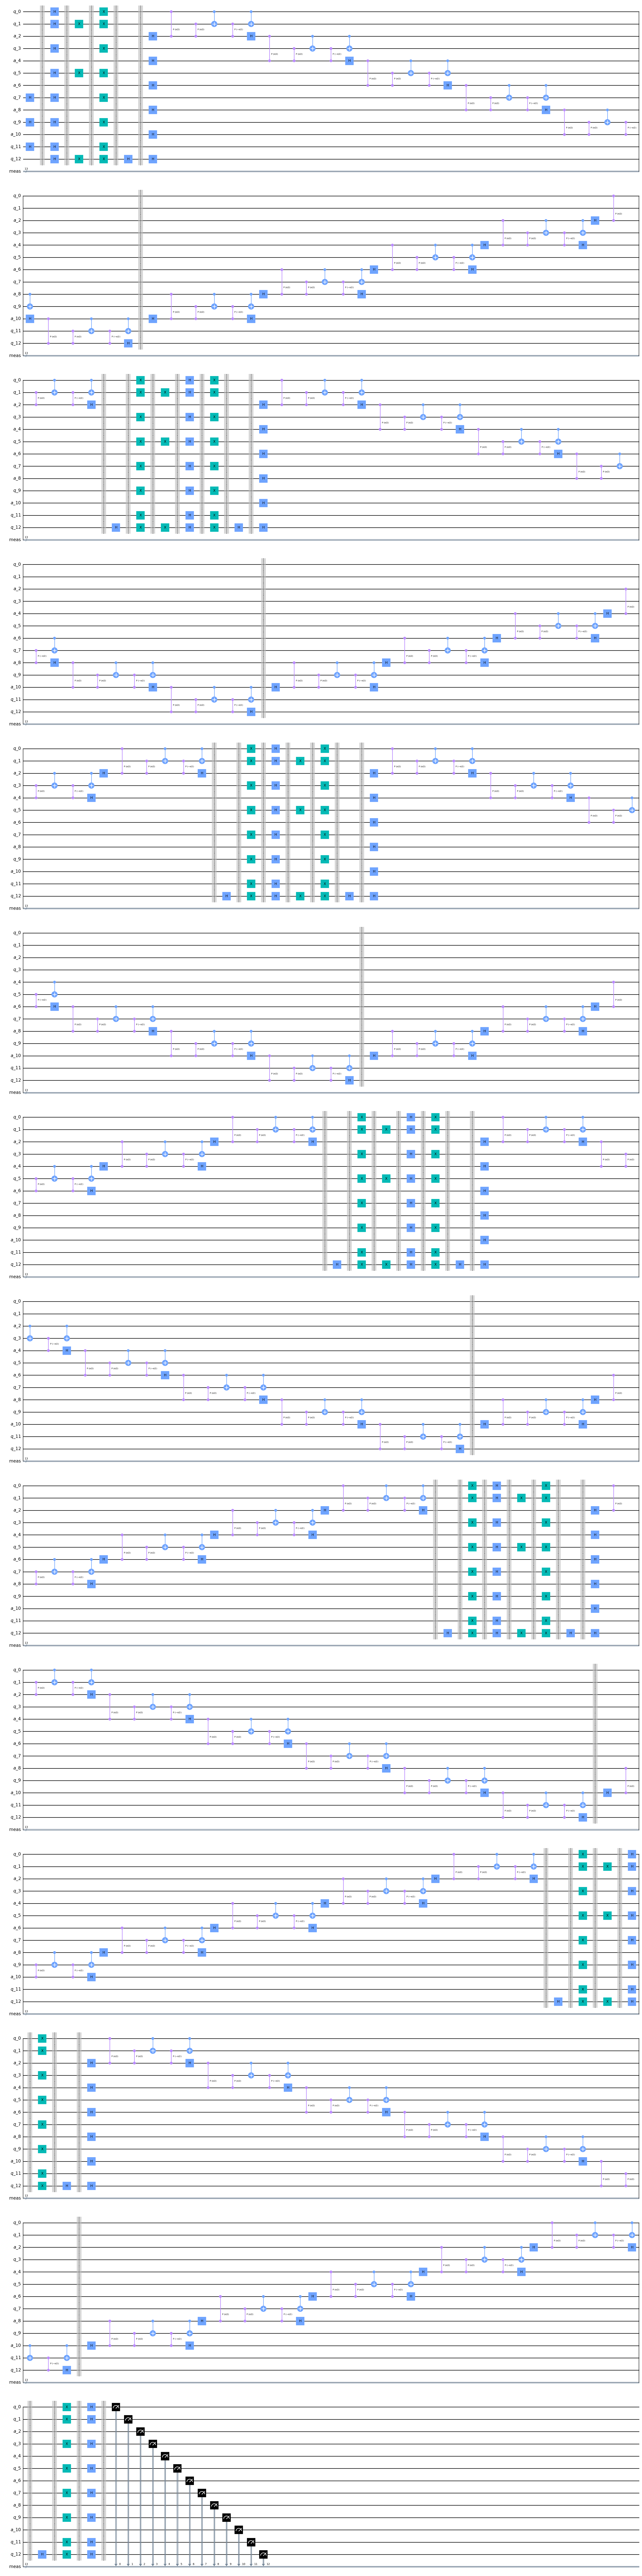

In [11]:
if N_iterations < 5:
    fig = circuit.draw("mpl", fold=50)
else:
    fig = None

fig

In [12]:
# Run the circuit, get counts
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("qasm_simulator")
job = execute(circuit, backend, shots=1024)
result = job.result()
counts = result.get_counts()

In [13]:
# Post preprocess the results of the Grover algorithm to remove ancillary qubits
Q = []
mask = ["q" if n.split("_")[0] == "q" else "a" for n in q_names]
for k in counts.keys():
    Q.append("".join([k[i] if mask[i] == "q" else "*" for i in range(len(k))]))

counts_q = {}
count_keys = counts.keys()
for x in Q:
    n_a = len(x.split("*")) - 1
    # all binary strings of length n_a
    A = [[x for x in bin(i)[2:].zfill(n_a)] + [""] for i in range(2**n_a)]
    Trace_A = []
    for a in A:
        Trace_A.append("".join([x + y for x, y in zip(x.split("*"), a)]))

    counts_q[x.replace("*", "")] = sum([counts[k] for k in Trace_A if k in count_keys])


### Results

Target state: 10001010 = 138

Interactions of Grover performed: 3
Optimal number of iterations: 12

State associate with the 5 largest number of count
['10001010', '10000001', '10001000', '00001001', '00000111']
Number of counts
[92, 27, 25, 25, 25]


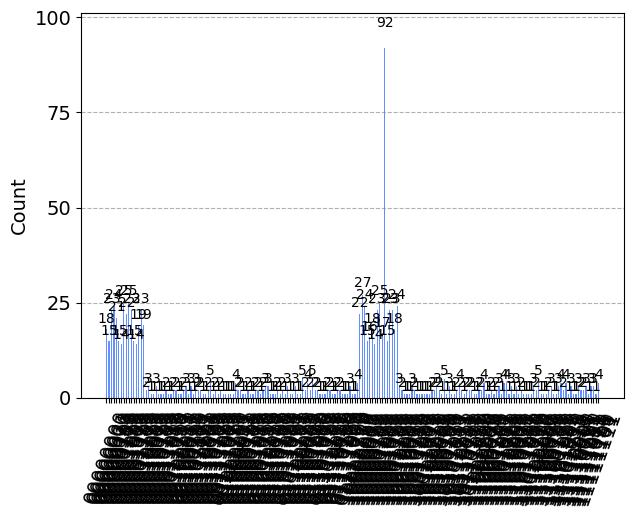

In [14]:
print("Target state:", Target_string, '=', int(Target_string, 2))

print("\nInteractions of Grover performed:", N_iterations)
print("Optimal number of iterations:", int((np.pi / 2 * np.sqrt(2**n) - 1) / 2))
print()

x = counts_q.keys()
y = counts_q.values()
# States associate with the 5 largest value of y
top_x = [x for _, x in sorted(zip(y, x), reverse=True)][:5]
top_y = sorted(y, reverse=True)[:5]

print("State associate with the 5 largest number of count")
print(top_x)
print("Number of counts")
print(top_y)

plot_histogram(counts_q)
